In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, roc_auc_score, recall_score, 
    precision_recall_curve, roc_curve, auc, classification_report, 
    confusion_matrix, f1_score
)
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split
)
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

In [340]:
import sklearn
print(sklearn.__version__)

1.5.1


# integrate data

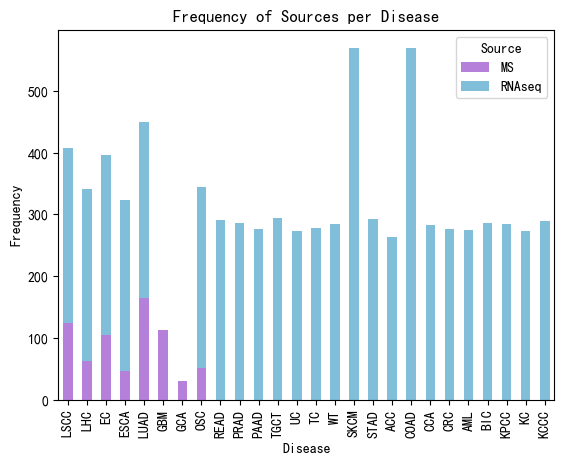

,ID,gene_name,logFC,adj.P.Val,TRIM,R,pValue,dataset,disease,source,...,group,TRIM_uid,complex_n,zrank_score,reported,VALUE,GO_dict,MF,BP,CC
4027,DDX5,DDX5,1.38624,0.00000,TRIM25,0.323981,1.915750e-06,LSCC_PMID34358469,LSCC,MS,...,CIV,Q14258,596.0,-106.4750,substrate,1.0,"{'MF': ['GO:0003723', 'GO:0005515'], 'CC': ['G...","GO:0003723,GO:0005515",NaN,"GO:0005654,GO:0005829,GO:0005737"
3703,PPM1A,PPM1A,-0.43370,0.00000,MID1,-0.461898,3.279559e-18,LHC_PMID31585088,LHC,MS,...,CI,O15344,1501.0,-98.8192,substrate,NaN,NaN,NaN,NaN,NaN
3702,PKM,PKM,0.50923,0.00000,TRIM33,0.311245,1.429016e-08,LHC_PMID31585088,LHC,MS,...,CVI,Q9UPN9,1250.0,-39.8420,substrate,NaN,NaN,NaN,NaN,NaN
3701,PFKP,PFKP,0.11954,0.09742,TRIM21,0.235983,2.120455e-05,LHC_PMID31585088,LHC,MS,...,CIV,P19474,513.0,-86.4552,substrate,1.0,"{'MF': ['GO:0005515', 'GO:0042802'], 'CC': ['G...","GO:0005515,GO:0042802",NaN,"GO:0005634,GO:0005737,GO:0005829"
3700,PCNA,PCNA,1.13623,0.00000,TRIM28,0.697066,1.420639e-47,LHC_PMID31585088,LHC,MS,...,CVI,Q13263,124.0,-29.7473,substrate,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,ENSG00000164924.17,YWHAZ,0.25564,0.03905,TRIM21,0.501890,3.640374e-31,ESCA_TCGA,ESCA,RNAseq,...,CIV,P19474,447.0,-46.9357,substrate,1.0,"{'MF': ['GO:0003723', 'GO:0005515', 'GO:001990...","GO:0003723,GO:0005515,GO:0019901,GO:0042802",GO:0045824,"GO:0005829,GO:0005634,GO:0005654,GO:0005737"
2668,ENSG00000108953.16,YWHAE,0.12751,0.23380,TRIM44,0.617949,1.595859e-50,ESCA_TCGA,ESCA,RNAseq,...,UC,Q96DX7,1.0,-100.4000,interactor,NaN,NaN,NaN,NaN,NaN
2667,ENSG00000137693.13,YAP1,-0.38431,0.00016,TRIM11,0.525361,1.712895e-34,ESCA_TCGA,ESCA,RNAseq,...,CIV,Q96F44,483.0,-35.4066,interactor,1.0,"{'MF': ['GO:0005515'], 'CC': ['GO:0005654', 'G...",GO:0005515,NaN,"GO:0005654,GO:0005737,GO:0005829"
2822,ENSG00000142208.15,AKT1,0.11908,0.12004,TRIM23,0.258361,4.578700e-11,KCCC_TCGA,KCCC,RNAseq,...,CIX,P36406,1568.0,-41.4375,substrate,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = pd.read_csv("F:/script/TRIMs/web_pancancer/reported_data.tsv", sep='\t').sort_values(by='source', ascending=True)
#可视化data['disease']中数据的频数
data.groupby(['disease', 'source'], sort=False).size().unstack().plot(kind='bar', stacked=True, color=['#a161d1', '#61aed1'], alpha=0.8)
plt.title('Frequency of Sources per Disease')
plt.ylabel('Frequency')
plt.xlabel('Disease')
plt.legend(title='Data source')  # Updated legend title
plt.savefig('F:/script/TRIMs/web_pancancer/reported_data.pdf', format='pdf')
plt.show()


# load data

In [497]:
reported_data = pd.read_csv('F:/script/TRIMs/web_pancancer/reported_data.tsv', sep='\t')
reported_data = reported_data[~reported_data['zrank_score'].isna() & reported_data['zrank_score'] != 0]
reported_data['CIV'] = reported_data['group'] == 'CIV'

# processing ms model
df = reported_data[reported_data['source'] == 'RNAseq']#[['disease','R','logFC','zrank_score','CIV']].dropna().reset_index(drop=True)
df['disease_code'] = df['disease'].astype('category').cat.codes 
print(len(df['disease'].unique()), len(df[df['CIV'] == True]), len(df[df['CIV'] == False]))
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# df.to_csv('F:/script/TRIMs/ML/panmodel/model250405/rnaseq_traindata.tsv', sep='\t', index=False)

24 3392 3912
Number of duplicate rows: 0


C:\Users\DELL\AppData\Local\Temp\ipykernel_24324\3666855995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disease_code'] = df['disease'].astype('category').cat.codes


In [499]:
np.random.seed(42)

#balanced sample
if len(df[df['CIV'] == True]) > len(df[df['CIV'] == False]):
    print("oversample false")
    df_false_sampled = resample(df[df['CIV'] == False], replace=True, n_samples=len(df[df['CIV'] == True]), random_state=42)
    df_balanced = pd.concat([df[df['CIV'] == True], df_false_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    print("undersample false")
    df_false_sampled = resample(df[df['CIV'] == False], replace=False, n_samples=len(df[df['CIV'] == True]), random_state=42)
    df_balanced = pd.concat([df[df['CIV'] == True], df_false_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[['disease_code', 'logFC', 'R','zrank_score']]
y = df_balanced['CIV']

#candidate models
KNN = KNeighborsClassifier()
NB = GaussianNB()
LDA = LinearDiscriminantAnalysis()
LR = LogisticRegression(max_iter=1000, random_state=42)
SVM = SVC(random_state=42, probability=True, max_iter=1000)
RF = RandomForestClassifier(random_state=42)
models = [RF, NB, LR, LDA,  KNN, SVM]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df_balanced

undersample false


,ID,gene_name,logFC,adj.P.Val,TRIM,R,pValue,dataset,disease,source,...,complex_n,zrank_score,reported,VALUE,GO_dict,MF,BP,CC,CIV,disease_code
0,ENSG00000143178.12,TBX19,-1.95043,0.00000,TRIM65,-0.168325,5.099474e-02,UC_TCGA,UC,RNAseq,...,301.0,-45.9933,substrate,NaN,NaN,NaN,NaN,NaN,True,22
1,ENSG00000145012.12,LPP,-0.17245,0.00426,TRIM21,0.425757,1.048820e-24,LHC_TCGA,LHC,RNAseq,...,724.0,-59.2354,substrate,1.0,"{'MF': ['GO:0005515'], 'CC': ['GO:0005634', 'G...",GO:0005515,NaN,"GO:0005634,GO:0005829",True,11
2,ENSG00000108953.16,YWHAE,1.33825,0.00000,TRIM44,0.662337,2.168023e-18,UC_TCGA,UC,RNAseq,...,1.0,-100.4000,interactor,NaN,NaN,NaN,NaN,NaN,False,22
3,ENSG00000108773.10,KAT2A,0.92657,0.00098,TRIM22,-0.066930,6.622294e-01,CCA_TCGA,CCA,RNAseq,...,1519.0,-37.8754,substrate,1.0,"{'MF': ['GO:0003713', 'GO:0005515'], 'BP': ['G...","GO:0003713,GO:0005515","GO:0006355,GO:0045893","GO:0005634,GO:0005654",True,3
4,ENSG00000127191.17,TRAF2,1.35199,0.00000,TRIM47,0.902932,2.589858e-129,PAAD_TCGA,PAAD,RNAseq,...,1952.0,-28.1204,substrate,1.0,"{'MF': ['GO:0004842', 'GO:0005515', 'GO:000827...","GO:0004842,GO:0005515,GO:0008270,GO:0061630",NaN,GO:0005829,True,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779,ENSG00000176170.13,SPHK1,-0.30117,0.02150,TRIM14,0.173323,1.671966e-04,ESCA_TCGA,ESCA,RNAseq,...,82.0,-118.9180,interactor,NaN,NaN,NaN,NaN,NaN,False,7
6780,ENSG00000127191.17,TRAF2,0.70909,0.00000,TRIM31,0.375100,2.200047e-18,OSC_TCGA,OSC,RNAseq,...,1050.0,-33.5779,substrate,NaN,NaN,NaN,NaN,NaN,False,14
6781,ENSG00000108468.14,CBX1,-0.12152,0.21930,TRIM24,0.554060,6.242465e-39,ESCA_TCGA,ESCA,RNAseq,...,212.0,-37.3133,interactor,NaN,NaN,NaN,NaN,NaN,False,7
6782,ENSG00000141510.15,TP53,1.41024,0.00000,TRIM31,0.416146,3.406589e-22,COAD_Transverse_TCGA,COAD,RNAseq,...,977.0,-59.1999,substrate,NaN,NaN,NaN,NaN,NaN,False,4


# primary performance evaluation

In [85]:
# primary evaluation
for model in models:
    y_true, y_pred, y_pred_prob = [], [], []
    if model in [KNN, LDA, LR, SVM]:
        X1 = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    else:
        X1 = X.copy()
    for train_idx, test_idx in cv.split(X1, y):
        X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred_prob_fold = model.predict_proba(X_test)[:, 1]
        y_pred_fold = model.predict(X_test)
        y_true.extend(y_test)
        y_pred.extend(y_pred_fold)
        y_pred_prob.extend(y_pred_prob_fold)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_prob = np.array(y_pred_prob)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() #所有交叉验证中的混淆矩阵
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
    aupr = auc(recall_vals, precision_vals)
    
    print(f"Model: {type(model).__name__}")
    print(f"Specificity (SPE): {specificity:.4f}")
    print(f"Accuracy (ACC): {accuracy:.4f}")
    print(f"Precision (PRE): {precision:.4f}")
    print(f"Recall (REC): {recall:.4f}")
    print(f"F1 Score (F1): {f1:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"Area Under the ROC Curve (AUROC): {roc_auc:.4f}")
    print(f"Area Under the Precision-Recall Curve (AUPR): {aupr:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")


Model: RandomForestClassifier
Specificity (SPE): 0.8340
Accuracy (ACC): 0.8648
Precision (PRE): 0.8437
Recall (REC): 0.8956
F1 Score (F1): 0.8689
Matthews Correlation Coefficient (MCC): 0.7310
Area Under the ROC Curve (AUROC): 0.9412
Area Under the Precision-Recall Curve (AUPR): 0.9381
Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.83      0.86      3392
        True       0.84      0.90      0.87      3392

    accuracy                           0.86      6784
   macro avg       0.87      0.86      0.86      6784
weighted avg       0.87      0.86      0.86      6784



Model: GaussianNB
Specificity (SPE): 0.3709
Accuracy (ACC): 0.6106
Precision (PRE): 0.5747
Recall (REC): 0.8502
F1 Score (F1): 0.6859
Matthews Correlation Coefficient (MCC): 0.2519
Area Under the ROC Curve (AUROC): 0.6419
Area Under the Precision-Recall Curve (AUPR): 0.5985
Classification Report:
              precision    recall  f1-score   support

       F

d:\annoconda3\envs\TRIM\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\annoconda3\envs\TRIM\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\annoconda3\envs\TRIM\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\annoconda3\envs\TRIM\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\annoconda3\envs\TRIM\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).

Model: SVC
Specificity (SPE): 0.5663
Accuracy (ACC): 0.5821
Precision (PRE): 0.5796
Recall (REC): 0.5979
F1 Score (F1): 0.5886
Matthews Correlation Coefficient (MCC): 0.1643
Area Under the ROC Curve (AUROC): 0.5915
Area Under the Precision-Recall Curve (AUPR): 0.5742
Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.57      0.58      3392
        True       0.58      0.60      0.59      3392

    accuracy                           0.58      6784
   macro avg       0.58      0.58      0.58      6784
weighted avg       0.58      0.58      0.58      6784





# SVM-hpo
https://mp.weixin.qq.com/s/CRnOlKh4d14da6QxIPsvvg

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
# joblib.dump(scaler, '')
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

np.bincount(y_test)

array([679, 678], dtype=int64)

In [501]:
#GridSearchCV-CV5
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 0, 4)),
}
# Initialize the SVM model
svm = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search.fit(X_train_s, y_train)
print("Best Parameters: ", grid_search.best_params_)
model = grid_search.best_estimator_
print("Best Score: ", model.score(X_test_s, y_test)) # accuracy


Best Parameters:  {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
Best Score:  0.6359616801768607


In [ ]:
# naive-bayes HPO
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from skopt.plots import plot_objective
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('model', SVC(probability=True, random_state=42))  # 设定初始模型为 SVC
])

svc_search = {
    'model': Categorical([SVC(probability=True, random_state=42)]),
    'model__C': Real(0.1, 10, prior='log-uniform'),
    'model__gamma': Categorical(['auto','scale',0.01, 0.1, 1]),
    'model__kernel': Categorical(['linear', 'rbf', 'sigmoid'])
}

opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=[(svc_search, 100)], 
    scoring='precision',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1, #所有可用的CPU并行
    random_state=42
)

opt.fit(X_train_s, y_train)
print("Best Parameters: ", opt.best_params_)
model = opt.best_estimator_
print("Best Score: ", model.score(X_test_s, y_test)) 

plot_objective(opt.optimizer_results_[0], dimensions=None, n_minimum_search=20, n_points=20, n_samples=200, size=2, zscale='linear', cmap='plasma')
plt.show()


# model performance after hyperparameter tuning

In [ ]:
np.set_printoptions(suppress=True)
# model = opt.best_estimator_
model = grid_search.best_estimator_
pred = model.predict(X_test_s)
proba = model.predict_proba(X_test_s)[:, 1]

conf_matrix = confusion_matrix(y_test, pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_test, pred)
precision = classification_report(y_test, pred, output_dict=True)['True']['precision']
recall = classification_report(y_test, pred, output_dict=True)['True']['recall']
f1 = classification_report(y_test, pred, output_dict=True)['True']['f1-score']
mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
roc_auc = roc_auc_score(y_test, proba)
precision_recall_curve_values = precision_recall_curve(y_test, proba)
aupr = auc(precision_recall_curve_values[1], precision_recall_curve_values[0])

# Print metrics
print(f"Specificity (SPE): {specificity:.4f}")
print(f"Accuracy (ACC): {accuracy:.4f}")
print(f"Precision (PRE): {precision:.4f}")
print(f"Recall (REC): {recall:.4f}")
print(f"F1 Score (F1): {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Area Under the ROC Curve (AUROC): {roc_auc:.4f}")
print(f"Area Under the Precision-Recall Curve (AUPR): {aupr:.4f}")
print("classification_report", classification_report(y_test, pred))

with PdfPages('F:/script/TRIMs/ML/panmodel/model250405/tmp_rna_final_evaluations_nb.pdf') as pdf:
    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=sns.light_palette("#a161d1", as_cmap=True), cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'], alpha=0.8, annot_kws={"size": 20})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    pdf.savefig()  # Save the current figure
    plt.close()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='#a161d1', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    pdf.savefig()  # Save the current figure
    plt.close()

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, proba)
    aupr = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='#61aed1', lw=2, label='Precision-Recall curve (area = %0.2f)' % aupr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    pdf.savefig()  # Save the current figure
    plt.close()

In [468]:
import shap
from matplotlib.backends.backend_pdf import PdfPages

# 创建一个 PDF 文件来保存所有图
pdf_path = 'F:/script/TRIMs/ML/panmodel/model250405/ms_shap_plots_grid.pdf'
with PdfPages(pdf_path) as pdf:
    # 计算 SHAP 值
    # model = opt.best_estimator_
    model = grid_search.best_estimator_
    # background = shap.sample(X_train_s, 100)  # 采样 100 个样本
    explainer = shap.KernelExplainer(model.predict, X_train_s)
    shap_values = explainer.shap_values(X_test_s)

    # 保存 SHAP 摘要图
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, show=False)
    pdf.savefig(bbox_inches='tight')
    plt.close()

    # 保存 SHAP 依赖图
    for feature in X.columns:
        shap.dependence_plot(feature, shap_values, X_test_s, feature_names=X.columns, show=False)
        plt.title(feature)
        pdf.savefig(bbox_inches='tight')
        plt.close()

    # 保存 SHAP 决策树图（Decision Plot）
    shap.decision_plot(explainer.expected_value, shap_values[1], X_test_s, feature_names=list(X.columns), show=False)
    pdf.savefig(bbox_inches='tight')
    plt.close()

print(f"All SHAP plots have been saved to {pdf_path}")


Using 596 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 150/150 [00:18<00:00,  8.24it/s]
C:\Users\DELL\AppData\Local\Temp\ipykernel_24324\471367919.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, show=False)


All SHAP plots have been saved to F:/script/TRIMs/ML/panmodel/model250405/ms_shap_plots_grid.pdf


# model compared

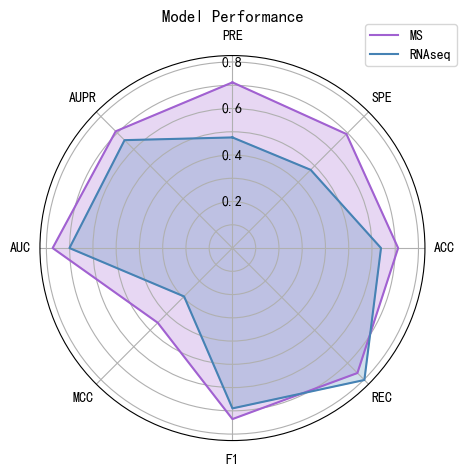

In [507]:
# radar metric
# metric_radar
import numpy as np
import matplotlib.pyplot as plt
eval_metric = pd.read_clipboard(sep='\t')
# Define the metrics and models
metrics = ['PRE', 'SPE', 'ACC', 'REC', 'F1', 'MCC', 'AUC', 'AUPR']
models = eval_metric['model'].tolist()

# Create a radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

colors = {'MS': '#a161d1', 'RNAseq': '#4682B4'}

for i, model in enumerate(models):
    values = eval_metric.loc[i, metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model, color=colors[model])
    ax.fill(angles, values, color=colors[model], alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Model Performance')
# Modify yticklabels to gray color and rotate them 45 degrees clockwise
ax.tick_params(axis='y', colors='gray', labelrotation=0)
for label in ax.get_yticklabels():
    label.set_rotation(0)

ax.set_yticklabels([])
y_ticks = np.arange(0.2, 1.0, 0.2)
for y in y_ticks:
    y = round(y, 2)
    ax.text(0, y, str(y), horizontalalignment='center', verticalalignment='center')

# Save the plot as a PDF
plt.savefig('F:/script/TRIMs/ML/panmodel/model250405/model_performance_radar_chart.pdf', format='pdf') 
plt.show()